In [1]:
# Data are from the Socorro USHCN site (298387)
# UHCN data browser is at http://cdiac.ornl.gov/epubs/ndp/ushcn/ushcn_map_interface.html
# data link: http://cdiac.ornl.gov/cgi-bin/broker?_PROGRAM=prog.climsite_monthly.sas&_SERVICE=default&id=298387&_DEBUG=0

# See the SPEI Socorro notebook
library('readr')
library('dplyr')
library('ggplot2')
library('forecast')
library('repr')

fname <- 'SPEI_out/socorro_1900_spei.csv'

df <- read_csv(fname)
head(df)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Parsed with column specification:
cols(
  Date = col_character(),
  cwdiff = col_double(),
  spei6mo = col_double(),
  spei12mo = col_double(),
  spei6mo_5Ymean = col_double(),
  spei6mo_adj5Ymean = col_double(),
  spei6mo_5Ysd = col_double(),
  spei6mo_adj5Ysd = col_double(),
  spei6mo_adj5Ycv = col_double()
)


Date,cwdiff,spei6mo,spei12mo,spei6mo_5Ymean,spei6mo_adj5Ymean,spei6mo_5Ysd,spei6mo_adj5Ysd,spei6mo_adj5Ycv
Jan 1900,33.901450,NA,NA,NA,NA,NA,NA,NA
Feb 1900,10.015018,NA,NA,NA,NA,NA,NA,NA
Mar 1900,-4.887078,NA,NA,NA,NA,NA,NA,NA
Apr 1900,-22.734462,NA,NA,NA,NA,NA,NA,NA
May 1900,-70.529805,NA,NA,NA,NA,NA,NA,NA
Jun 1900,-121.886952,0.9030355,NA,NA,NA,NA,NA,NA


In [2]:
# Make a timeseries
spei6 <- ts(df$spei6mo[12:length(df$spei6mo)], frequency=12, start=c(1901, 1))
spei12 <- ts(df$spei12mo[12:length(df$spei12mo)], frequency=12, start=c(1901, 1))

## Check for seasonal lags and autocorrelation

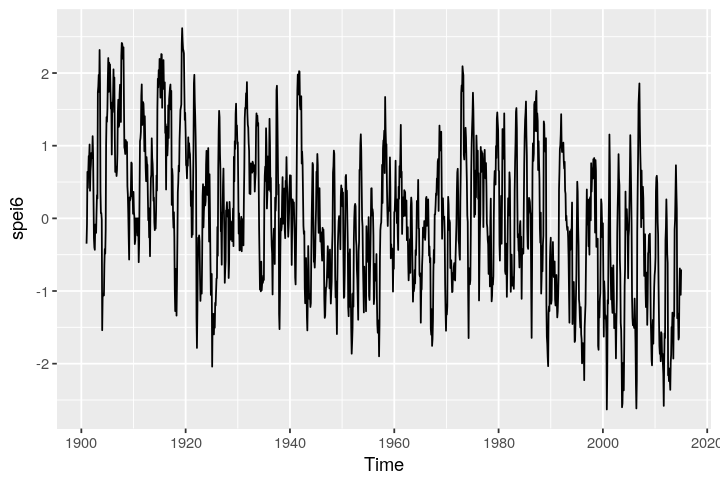

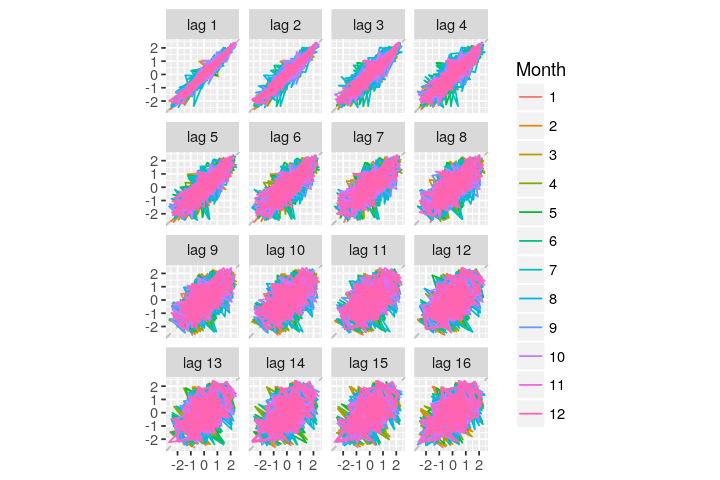

In [3]:
options(repr.plot.width=6, repr.plot.height=4)
autoplot(spei6)
gglagplot(spei12)
# There is diminishing autocorrelation up to lag of 6/12, but no evidence of seasonality (lag 12)

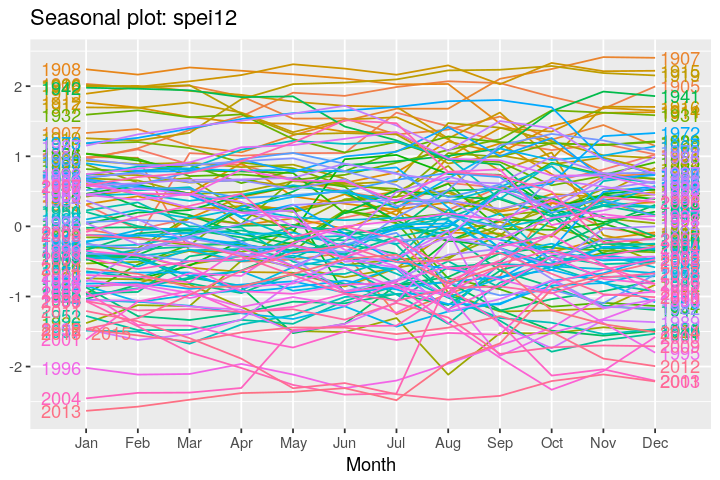

In [4]:
ggseasonplot(spei12, year.labels=TRUE, year.labels.left=TRUE)
# Not much evidence of seasonality here

## Seasonal heatmaps of spei

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last



             spei6 spei12 month year
Jan 1900        NA     NA     1 1900
Feb 1900        NA     NA     2 1900
Mar 1900        NA     NA     3 1900
Apr 1900        NA     NA     4 1900
May 1900        NA     NA     5 1900
Jun 1900 0.9030355     NA     6 1900

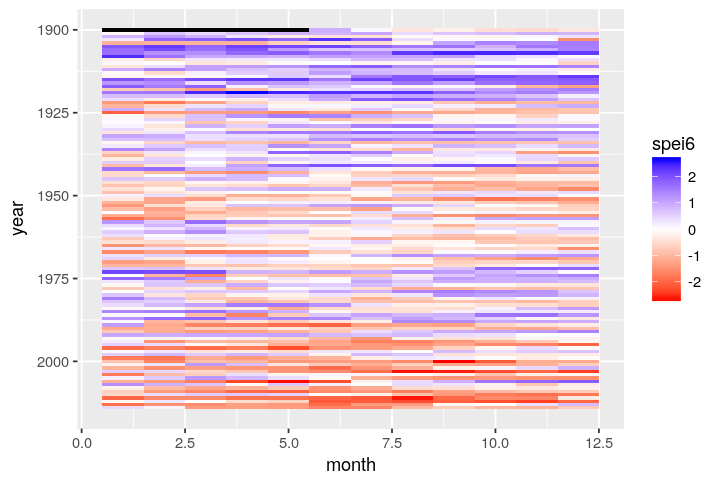

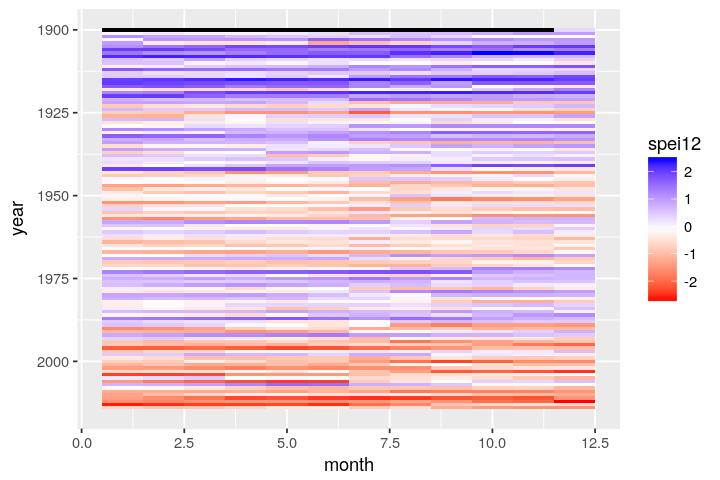

In [5]:
library('xts')
new <- as.xts(df$spei6mo, order.by=as.yearmon(df$Date))
colnames(new) <- c('spei6')
new$spei12 <- as.xts(df$spei12mo, order.by=as.yearmon(df$Date))
new$month <- format(index(new),"%m")
new$year <- format(index(new),"%Y")
head(new)
                      


# create y-axis breaks and labels
#lab <- with(new, paste(format(new$spei12, "%H"), "00", sep = ":"))

gg6 <- ggplot(data = new, aes(x = month, y = year, fill = spei6)) +
    geom_tile() + 
    scale_y_continuous(trans = "reverse")+
    scale_fill_gradientn(colours = c("red", "white", "blue"),
                         breaks=c(-2,-1,0,1,2),
                         na.value = "black")

gg6

gg12 <- ggplot(data = new, aes(x = month, y = year, fill = spei12)) +
    geom_tile() + 
    scale_y_continuous(trans = "reverse")+
    scale_fill_gradientn(colours = c("red", "white", "blue"),
                         breaks=c(-2,-1,0,1,2),
                         na.value = "black")

gg12

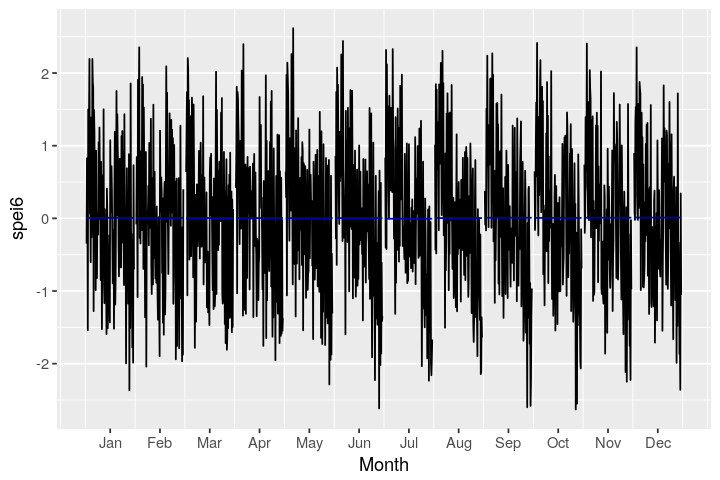

In [6]:
ggsubseriesplot(spei6)
# Again - no seasonality, but definitely the spei trend varies by month (more negative in summer/fall)

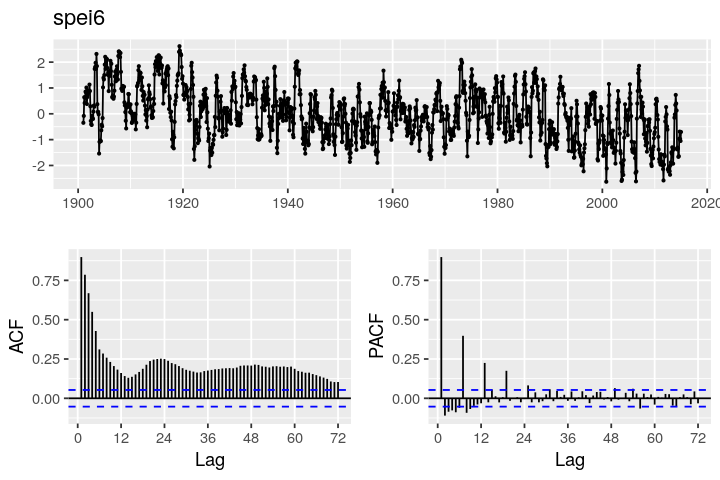

In [7]:
ggtsdisplay(spei6, lag=72)
# Strong autocorrelation for first 6/12 months, then a trend (slowly declining acf)
# Not really any regular peaks, so weak to no seasonality

Warning message in adf.test(spei12, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  spei12
Dickey-Fuller = -8.8562, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


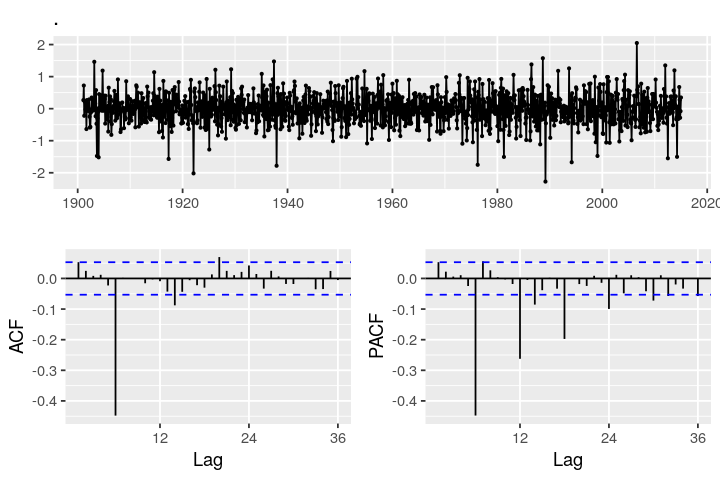

In [8]:
# PRetty clear the timeseries is not stationary. Check ADF test
# and the effect of differencing
library('tseries')
adf.test(spei12, alternative = "stationary")
spei6 %>% diff() %>% ggtsdisplay

# One diff makes timeseries appear stationary, but according
# ADF test it already is... Tested some ARIMAs below and using a differencing
# in the model (middle order > 0) does not seem good
# But there is still autocorrelation (peak at lag 6)

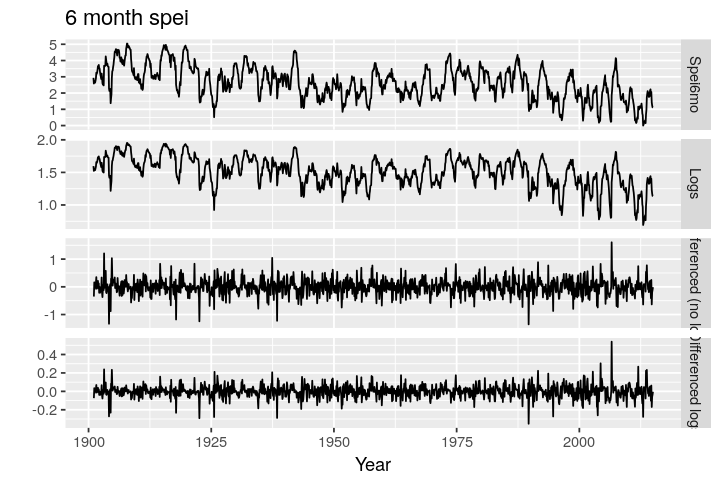

In [9]:
spei <- spei12
cbind("Spei6mo" = spei - min(spei),
      "Logs" = log(spei - min(spei) + 2),
      "Differenced (no log)" = diff(spei),
      "Differenced logs" = diff(log(spei - min(spei) + 2))) %>%
  autoplot(facets=TRUE) +
    xlab("Year") + ylab("") +
    ggtitle("6 month spei")

## Try some ARIMA fits for SPEI


	Ljung-Box test

data:  residuals
Q* = 133.94, df = 23, p-value < 2.2e-16

Model df: 1.   Total lags used: 24



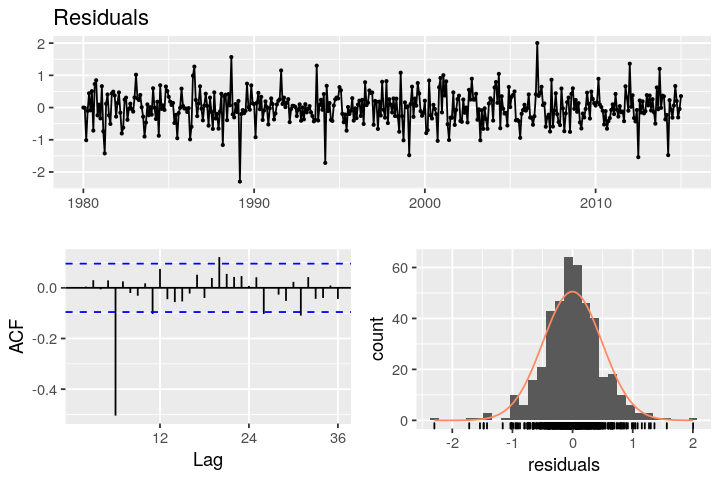

In [10]:
fit0 <- auto.arima(window(spei6, start=1980), seasonal=FALSE, allowdrift=TRUE)
checkresiduals(fit0)
# Not so good

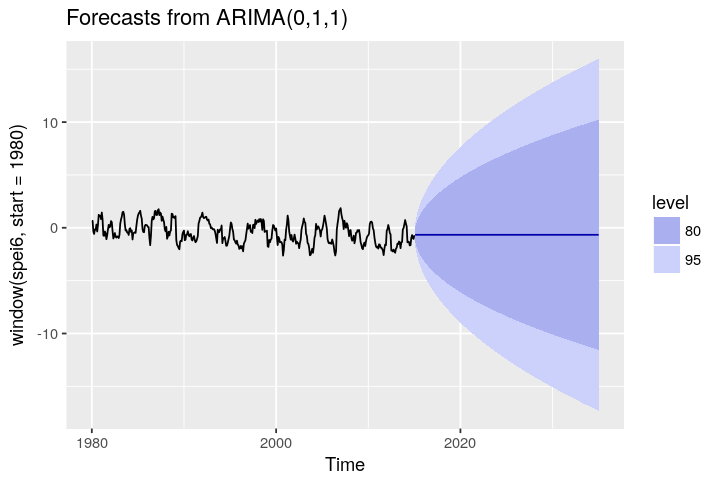

In [11]:
fit0 %>% forecast(h=12*20) %>% autoplot()


	Ljung-Box test

data:  residuals
Q* = 13.03, df = 12, p-value = 0.3668

Model df: 12.   Total lags used: 24



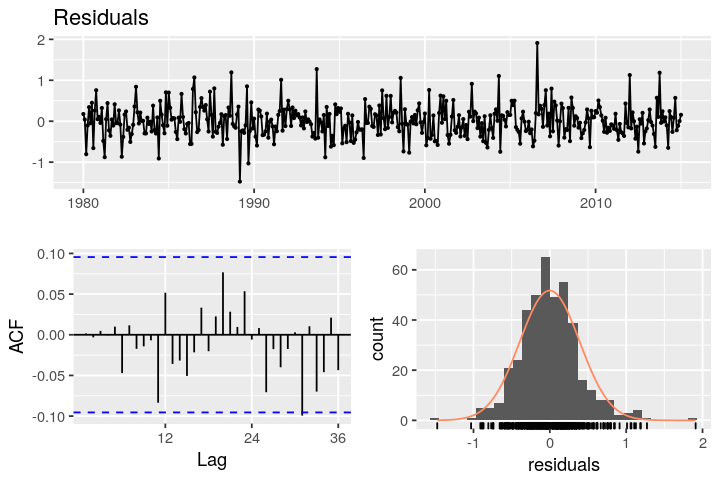

In [12]:
fit1 <- Arima(window(spei6, start=1980), order=c(5,0,5), include.drift=TRUE)
checkresiduals(fit1)

# This seems pretty good

## USING THIS FORECAST MODEL (for now)

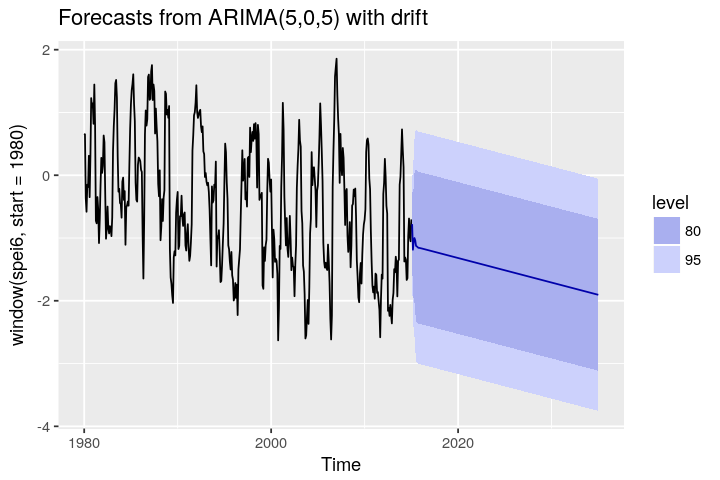

In [13]:
fit1 %>% forecast(h=240) %>% autoplot

### Simulate SPEI into the future

ar1          ar2          ar3          ar4          ar5          ma1 
 0.111674455  0.013773647  0.085983692 -0.040532347 -0.011251104  0.961916434 
         ma2          ma3          ma4          ma5    intercept        drift 
 0.871458877  0.742219834  0.732012983  0.698755375  0.247802268 -0.003256441

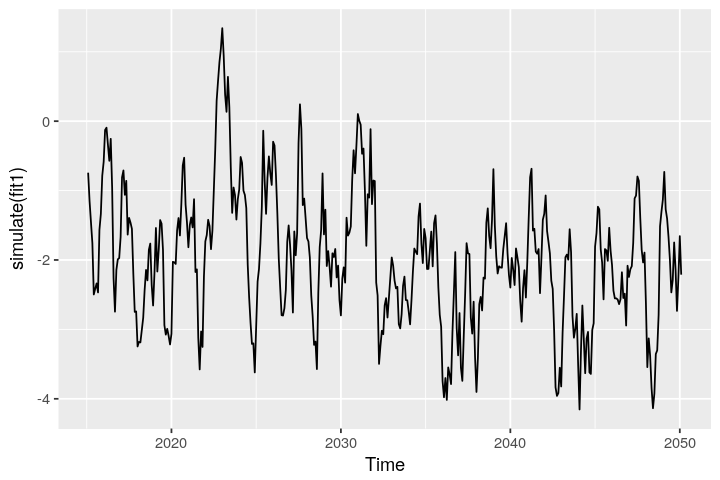

In [14]:
coef(fit1)
# The stuff below tries to do the simulation with arima.sim
#e <- rnorm(12*30,0,0.345)
#arc <- as.vector(coef(fit1)[1:5])
#mac <- as.vector(coef(fit1)[6:10])
#trend <- coef(fit1)[12]
#int <- coef(fit1)[11]
#print(length(df$spei6mo))
#startinn <- df$spei6mo[(length(df$spei6mo)-10):length(df$spei6mo)]
#ts.sim <- arima.sim(n=12*30,model=list(ar=arc, ma=mac),start.innov=startinn,n.start=10)

#sim <- ts(ts.sim, frequency=12, start=c(2015, 2))
#trend <- ts(((1:360)*trend) + int, frequency=12, start=c(2015, 2))
#autoplot(sim + trend)

# This is the automatic way with forecast (which I think calls arima.sim but it must do it better than me)
autoplot(simulate(fit1))

library('zoo')
# This should get us out to 2070
nsimlen <- length(window(spei6, start=1980))+(21*12)
sim <- as.zoo(simulate(fit1, nsim=nsimlen))
write.zoo(sim, 'spei6mo_sim.csv')

## Some other models... not used for now

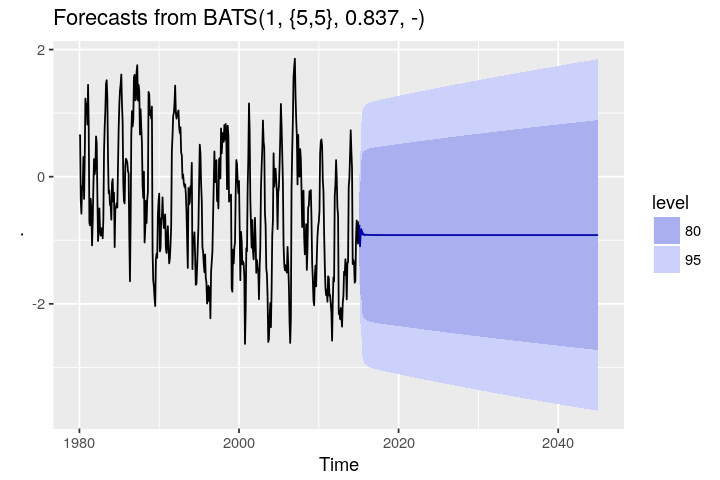

In [15]:
window(spei6, start=1980) %>% tbats(use.trend=TRUE) -> fit3
autoplot(forecast(fit3, h=12*30))

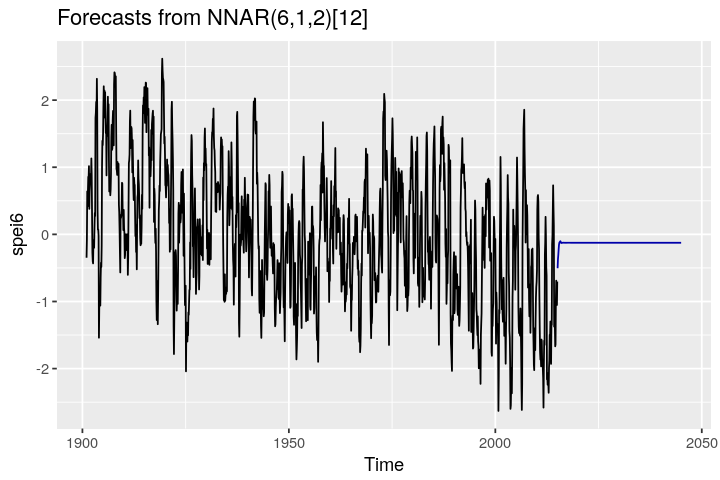

In [16]:
fit <- nnetar(spei6, 6, P=1, size=2)
autoplot(forecast(fit,h=12*30))

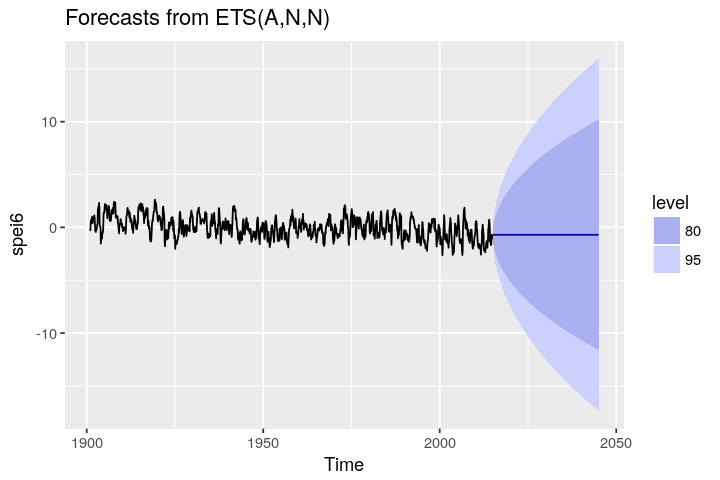

In [17]:
autoplot(forecast(spei6,h=12*30))